# Project One
## Supervised Learning
## Project: Analysis of ML algorithms on Census data

## Introduction

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first five record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Total number of records
n_records = data['workclass'].count()

# Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(data['income'] == '>50K')

# Number of records where individual's income is at most $50,000
n_at_most_50k = np.sum(data['income'] == '<=50K')

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of Individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of Individuals making more than $50,000: 24.78439697492371%


### Features of the dataset

** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

/Users/yonasbdaba/Desktop/GT P1 Final/visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


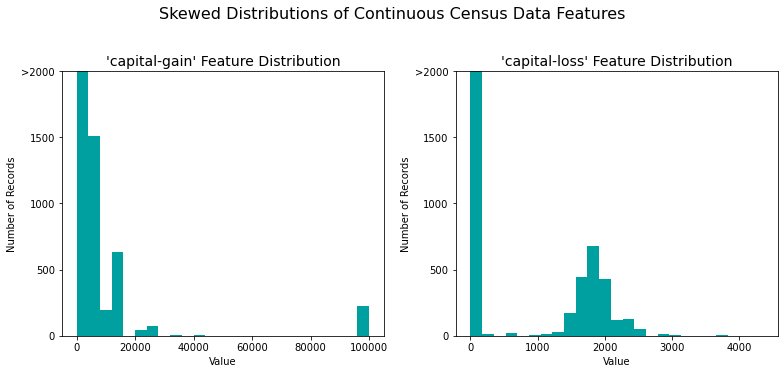

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

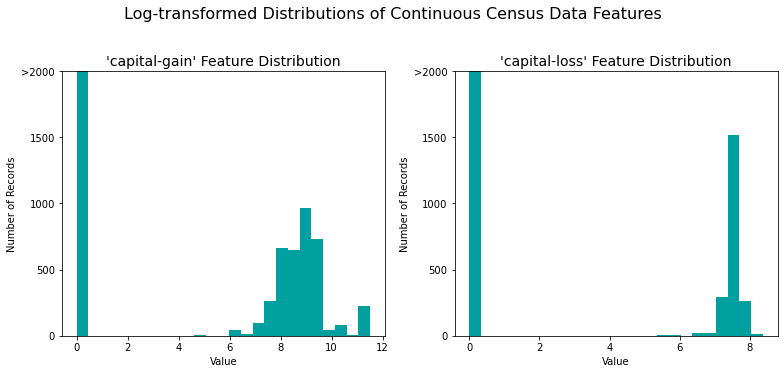

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)


### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [9]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ">50K" else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# the encoded feature names
print (encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [10]:
# displaying the top 5 features
display(features_final.head(n=5))

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate five different supervised learning algorithms, and determine which is best at modeling the data. These five learning algorithms are - Decision Trees with some form of prunning, Support Vector Machines, Boosting (Ada-boost), K-Nearest Neighbors, and Neural Networks.

### Metrics 

We are particularly interested in predicting who makes more than 50k accurately.It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. But for the sake of our argument let's assume we are using this problem set to in a nonprofit setup and let's assume this nonprofit is trying to use our analysis to find individuals who make 50K or more so as to ask for donations. With this in mind, identifying someone that does not make more than $50k as someone who does would be detrimental to the nonprofit, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than 50k is more important than the model's ability to recall those individuals. Therefore, we can use F-beta score as a metric that considers both precision and recall:


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most $50k, and those who make more), it's clear most individuals do not make more than 50k. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than 50k"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

## Model Implemenation : Decision Trees

In [63]:
# import the necessary libaries
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Learning Curve for Decision Trees

### NOTE: 
This piece of code for drawing learning curves is taken from the site : 
https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

Learning curves plot the training and validation loss of a sample of training examples by incrementally adding new training examples. Learning curves help us in identifying whether adding additional training examples would improve the validation score (score on unseen data). If a model is overfit, then adding additional training examples might improve the model performance on unseen data. Similarly, if a model is underfit, then adding training examples doesn’t help. ‘learning_curve’ method can be imported from Scikit-Learn’s ‘model_selection’ module as shown above.

Decision Tree model to the Census data and returns cross validation scores, train score and learning curve data.


In [21]:
#### NOTE : This piece of code for drawing learning curves is taken from the site : 
###https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    dtree = DecisionTreeClassifier(random_state=0)
    # Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',dtree]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=0)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

We’ll use the ‘learn_curve’ function to get a good fit model by setting the inverse regularization variable/parameter ‘c’ to 1 (i.e. we are not performing any regularization).

Cross Validation Accuracies:
-------------------------
[0.8138197899391929, 0.8195688225538972, 0.8205440070765149, 0.8186643078283945, 0.8220919946926138]

Mean Cross Validation Accuracy:
-------------------------
0.8189377844181227

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.002799852129821319

Training Accuracy:
---------------
0.9699261421432046




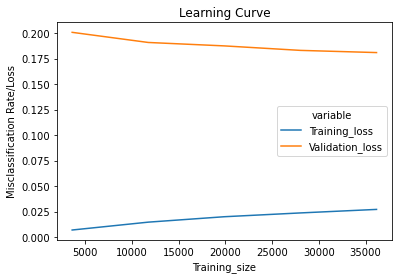

In [69]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

### Speed of Decision Trees on the training data set

In [18]:
%%time
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train,y_train)


CPU times: user 490 ms, sys: 42.3 ms, total: 533 ms
Wall time: 535 ms


DecisionTreeClassifier(random_state=0)

### Speed of Decison Trees on the testing data set

In [19]:
%%time
predictions = dtree.predict(X_test)

CPU times: user 12 ms, sys: 10 ms, total: 22 ms
Wall time: 20.7 ms


## Cross validation scores for training and testing data sets

In [37]:
# importing the necessary libraries 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
DT_training_labels = dtree.predict(X_train) 
DT_test_labels = dtree.predict(X_test)

# printing the cross validation scores
print("Cross validation scores for training labels")
print("Training accuracy score before pruning:",accuracy_score(y_train, DT_training_labels))
print("Training precision score before pruning:",precision_score(y_train, DT_training_labels))
print("Training recall score before pruning:",recall_score(y_train, DT_training_labels))
print("Training F1-score before pruning:",f1_score(y_train, DT_training_labels))
print("Training Fbeta-score before pruning:",fbeta_score(y_train, DT_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score before pruning:",accuracy_score(y_test, DT_test_labels))
print("Testing precision score before pruning:",precision_score(y_test, DT_test_labels))
print("Testing recall score before pruning:",recall_score(y_test, DT_test_labels))
print("Testing F1-score before pruning:",f1_score(y_test, DT_test_labels))
print("Testing Fbeta-score before pruning:",fbeta_score(y_test, DT_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score before pruning: 0.9725239793238798
Training precision score before pruning: 0.9791791312672011
Training recall score before pruning: 0.9089192491391759
Training F1-score before pruning: 0.942741935483871
Training Fbeta-score before pruning: 0.964271405340435


Cross validation scores for testing(validataion) labels
Testing accuracy score before pruning: 0.8182421227197346
Testing precision score before pruning: 0.6300417246175244
Testing recall score before pruning: 0.6163265306122448
Testing F1-score before pruning: 0.6231086657496561
Testing Fbeta-score before pruning: 0.6272500692328995



##### confusion matrix plot 
True positive (TP) : 6042
True negative (TN) : 1359
False postive (FP - type 1 error ) : 798
False negative (FN - type 2 error ) : 846

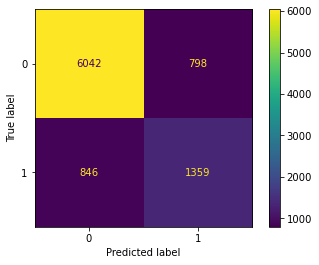

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=dtree.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
display.plot()
plt.show()

### ROC (Area under the curve) plot

Reference : 

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used#:~:text=ROC%20curves%20are%20frequently%20used,test(s)%20in%20question.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between individuals making 50k or above and individulas making less than 50k. The higher the ROC the better. 

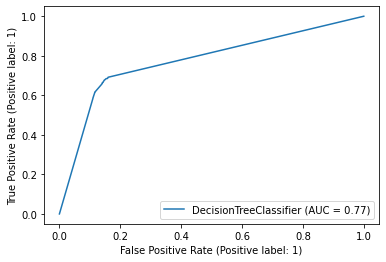

In [21]:
from sklearn.metrics import RocCurveDisplay
dtree_roc = RocCurveDisplay.from_estimator(dtree, X_test, y_test)
plt.show()

## Implementation : Decision Trees with cost_complexity_prunning_path 

The DecisionTreeClassifier class in sklearn provides ccp_alpha as a parameter for post pruning. The parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. The DecisionTreeClassifier class also provides a method cost_complexity_pruning_path which implements the pruning process and returns the effective alphas(and the corresponding impurities of there pruned trees)


In [56]:
#pruning by cost complexity
dtree = DecisionTreeClassifier(random_state=0)
path = dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Plotting the alphas vs impurities(except the last alpha corresponding to root node):

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

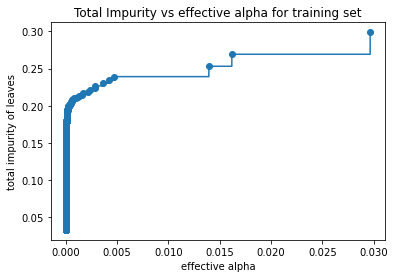

In [25]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

we build a forest of trees with different values of ccp_alpha values extracted from cost_complexity_pruning_path in order. The last tree will be the root node.

In [57]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1,ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [81]:
print("Number of nodes in the last tree is: {} with ccp_alpha: {} and a depth of: {}".format(
clfs[-1].tree_.node_count, ccp_alphas[-1],clfs[-1].tree_.max_depth))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07494023920830611 and a depth of: 1


The last tree in the ‘list’ clfs has the highest ccp_alpha value, it has three nodes tree with a depth of one. We can remove this tree and continue.


In [58]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

We plot how the different values of ccp_alpha influence the number of nodes and depth of the corresponding pruned trees.


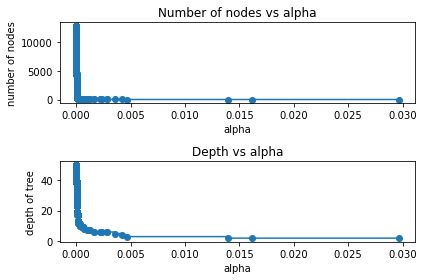

In [28]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

The plot shows that with the zero value of effective alpha the tree generated has the highest number of nodes and is the deepest(grows to the maximum), while as the effective alpha increases the trees are more pruned and have relatively fewer nodes and less deeper.

We get the list of train and test mean accuracy scores for each of the (remaining) trees and check how train/test accuracy scores change w.r.t the change in ccp_alpha.

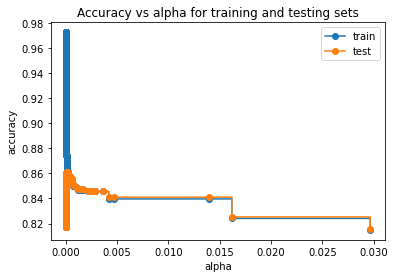

In [88]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

##### Speed on training dataset after prunning 

In [32]:
%%time
best_model.fit(X_train,y_train)

CPU times: user 526 ms, sys: 13.2 ms, total: 539 ms
Wall time: 537 ms


DecisionTreeClassifier(ccp_alpha=7.524731797059519e-05, random_state=1)

#### Speed on testing dataset after pruning

In [33]:
%%time
predictions = best_model.predict(X_test)

CPU times: user 6.9 ms, sys: 2.79 ms, total: 9.69 ms
Wall time: 7.72 ms


With the initial smaller values of alpha, there is a huge disparity between the training and test accuracy scores. 
When the alpha value increases, the training accuracy decreases, and the test accuracy increases until we reach the optimal point(highest test accuracy score). In the plot, the optimal point lies between 0 to 0.005 of alpha, where we get the optimal pruned tree. Beyond this point with an increase in alpha, the tree is over pruned. This eventually leads to under-fitting, both the training and test accuracy scores decrease.


In [34]:
# importing the necessary libraries 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
DT_training_labels = best_model.predict(X_train) 
DT_test_labels = best_model.predict(X_test)

#printing cross validaton scores
print("Cross validation scores for training labels")
print("Training accuracy score after pruning:",accuracy_score(y_train, DT_training_labels))
print("Training precision score after pruning:",precision_score(y_train, DT_training_labels))
print("Training recall score after pruning:",recall_score(y_train, DT_training_labels))
print("Training F1-score after pruning:",f1_score(y_train, DT_training_labels))
print("Training Fbeta-score after pruning:",fbeta_score(y_train, DT_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score after pruning:",accuracy_score(y_test, DT_test_labels))
print("Testing precision score after pruning:",precision_score(y_test, DT_test_labels))
print("Testing recall score after pruning:",recall_score(y_test, DT_test_labels))
print("Testing F1-score after pruning:",f1_score(y_test, DT_test_labels))
print("Testing Fbeta-score after pruning:",fbeta_score(y_test, DT_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score after pruning: 0.8719628493241562
Training precision score after pruning: 0.7962586417242782
Training recall score after pruning: 0.6524491836054649
Training F1-score after pruning: 0.7172161172161172
Training Fbeta-score after pruning: 0.7626392459297344


Cross validation scores for testing(validataion) labels
Testing accuracy score after pruning: 0.861028192371476
Testing precision score after pruning: 0.7642140468227425
Testing recall score after pruning: 0.6217687074829932
Testing F1-score after pruning: 0.6856714178544636
Testing Fbeta-score after pruning: 0.7307323313079629



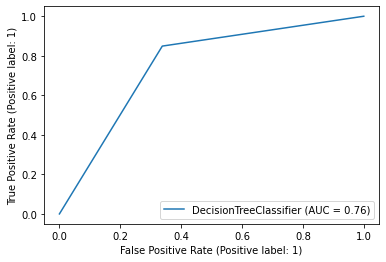

In [59]:
from sklearn.metrics import RocCurveDisplay
clf_roc = RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

## Improving Results (Improving Decision Tree model performance)

In this section, we will perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 2 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

##### NOTE : Acknowledgment : https://ai.plainenglish.io/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

#### What is Grid Search?
Grid search is a technique for tuning hyperparameter that may facilitate build a model and evaluate a model for every combination of algorithms parameters per grid.
We might use 10 fold cross-validation to search the best value for that tuning hyperparameter. Parameters like in decision criterion, max_depth, min_sample_split, etc. These values are called hyperparameters. To get the simplest set of hyperparameters we will use the Grid Search method. In the Grid Search, all the mixtures of hyperparameters combinations will pass through one by one into the model and check the score on each model. It gives us the set of hyperparameters which gives the best score. Scikit-learn package as a means of automatically iterating over these hyperparameters using cross-validation. This method is called Grid Search.


#### How does it work?
Grid Search takes the model or objects you’d prefer to train and different values of the hyperparameters. It then calculates the error for various hyperparameter values, permitting you to choose the best values.

In [22]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
#parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}
#parameters = {'n_estimators':[75,200,500]}
parameters = {"criterion":['gini','entropy'],
              "max_depth":range(1,20),
              "min_samples_split":range(1,10),
              "min_samples_leaf":range(1,5)}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)


# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
#best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
760 fits failed out of a total of 6840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
760 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater

Unoptimized model
------
Accuracy score on testing data: 0.8182
F-score on testing data: 0.6273

Optimized Model
------
Final accuracy score on the testing data: 0.8549
Final F-score on the testing data: 0.7226


### Finding the best Hyperparameters


In [23]:
grid_fit.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       min_samples_split=9, random_state=0)

### ROC( Area under the curve) plot for optimized Decision Trees

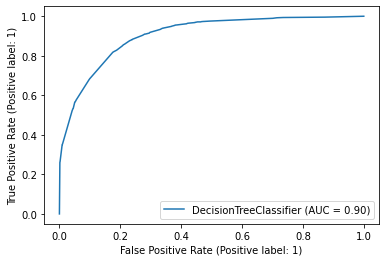

In [24]:
from sklearn.metrics import RocCurveDisplay
best_clf_roc = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

### Final Decision Tree Model Evaluation ( Unoptimized vs Optimized )

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8182           |  0.8549         |
| F-score        |  0.6273           |  0.7226         |

**Answer: ** 

The result shows that the optimized model performs much better after the hyperparameter tunning. 

# Model Implemenation : Support Vector Machines (SVMs)

In [35]:
from sklearn.svm import SVC
svm_model = SVC(random_state=0)

In [39]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    svm = svm_model
   # Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',svm]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.839690436705362, 0.8383637368711996, 0.8416629809818664, 0.8393409995577178, 0.8411101282618311]

Mean Cross Validation Accuracy:
-------------------------
0.8400336564755954

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.001199974562647473

Training Accuracy:
---------------
0.8529919065941356




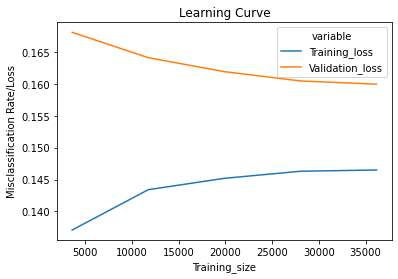

In [98]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

### Speed of SVMs on the training data set

In [43]:
%%time
svm = SVC(random_state=0)
svm.fit(X_train,y_train)

CPU times: user 1min 23s, sys: 576 ms, total: 1min 24s
Wall time: 1min 24s


SVC(random_state=0)

### Speed of SVMs on the testing data set

In [44]:
%%time
predictions = svm.predict(X_test)

CPU times: user 29.1 s, sys: 69.8 ms, total: 29.1 s
Wall time: 29.2 s


In [45]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6840
           1       0.71      0.59      0.65      2205

    accuracy                           0.84      9045
   macro avg       0.79      0.76      0.77      9045
weighted avg       0.84      0.84      0.84      9045



In [31]:
#Cross validation training & testing accuracy 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
SVM_training_labels = svm.predict(X_train) 
SVM_test_labels = svm.predict(X_test)
print("Cross validation scores for training labels")
print("Training accuracy score :",accuracy_score(y_train, SVM_training_labels))
print("Training precision score :",precision_score(y_train, SVM_training_labels))
print("Training recall score :",recall_score(y_train, SVM_training_labels))
print("Training F1-score score :",f1_score(y_train, SVM_training_labels))
print("Training Fbeta-score :",fbeta_score(y_train, SVM_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score :",accuracy_score(y_test, SVM_test_labels))
print("Testing precision score :",precision_score(y_test, SVM_test_labels))
print("Testing recall score :",recall_score(y_test, SVM_test_labels))
print("Testing F1-score score:",f1_score(y_test, SVM_test_labels))
print("Testing Fbeta-score score:",fbeta_score(y_test, SVM_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score : 0.8477762114050363
Training precision score : 0.7384720327421556
Training recall score : 0.6012440297678552
Training F1-score score : 0.6628298536704832
Training Fbeta-score : 0.7062338543433447


Cross validation scores for testing(validataion) labels
Testing accuracy score : 0.8423438363736871
Testing precision score : 0.71412864211105
Testing recall score : 0.5891156462585034
Testing F1-score score: 0.6456262425447316
Testing Fbeta-score score: 0.685054319164645



##### confusion matrix plot 
True positive (TP) : 6320
True negative (TN) : 1299
False postive (FP - type 1 error ) : 520
False negative (FN - type 2 error ) : 906

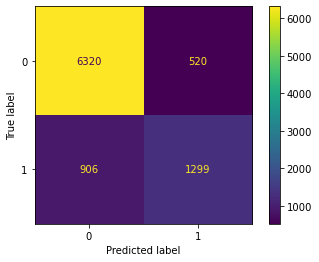

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
svm = SVC(random_state=0)
svm.fit(X_train,y_train)
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
display.plot()
plt.show()

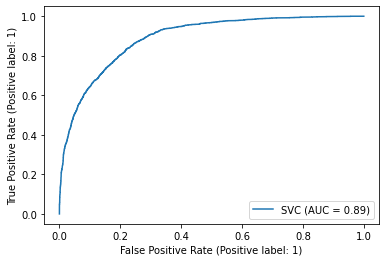

In [49]:
from sklearn.metrics import RocCurveDisplay
svm_roc = RocCurveDisplay.from_estimator(svm, X_test, y_test)
plt.show()

## Improving Results (Improving SVM model performance)

In this section, we will perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [37]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC


# Initialize the classifier
clf = SVC(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = { 'C':[100,1000],
              'kernel':['rbf'],
              'gamma': [0.01,0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
#best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8423
F-score on testing data: 0.6851

Optimized Model
------
Final accuracy score on the testing data: 0.8451
Final F-score on the testing data: 0.6906


### Finding the best Hyperparameters

In [38]:
grid_fit.best_estimator_

SVC(C=1000, gamma=0.01, random_state=0)

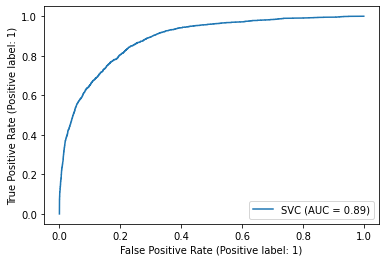

In [41]:
from sklearn.metrics import RocCurveDisplay
best_clf_roc = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

### Final Support Vector Machine Model Evaluation ( Unoptimized vs Optimized )

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8423           |  0.8451         |
| F-score        |  0.6851           |  0.6906         |

**Answer: ** 

The result shows that the optimized model performs much better than the unoptimized model.

# Model Implementation : Boosting ( Ada-Boost)

In [42]:
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [43]:
adaboost = AdaBoostClassifier(random_state=0)

In [13]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    boosting = adaboost
# Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',boosting]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.861028192371476, 0.8543946932006633, 0.8572534276868642, 0.8582485625829279, 0.8544891640866873]

Mean Cross Validation Accuracy:
-------------------------
0.8570828079857238

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.00248624627047793

Training Accuracy:
---------------
0.8571934014417761




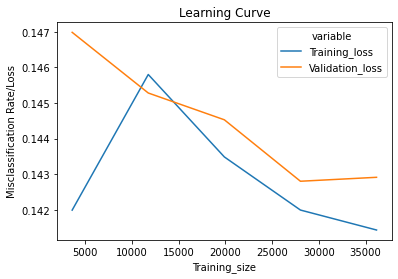

In [14]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

### Speed of Ada-boost on the training data set

In [44]:
%%time
adaboost = AdaBoostClassifier(random_state=0)
adaboost.fit(X_train,y_train)

CPU times: user 2.39 s, sys: 278 ms, total: 2.67 s
Wall time: 2.68 s


AdaBoostClassifier(random_state=0)

### Speed of Ada-boost on the testing data set

In [45]:
%%time
predictions = adaboost.predict(X_test)

CPU times: user 147 ms, sys: 4.79 ms, total: 152 ms
Wall time: 151 ms


In [58]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6840
           1       0.76      0.60      0.67      2205

    accuracy                           0.86      9045
   macro avg       0.82      0.77      0.79      9045
weighted avg       0.85      0.86      0.85      9045



### Cross validation scores for training and testing data sets

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
ada_training_labels = adaboost.predict(X_train) 
ada_test_labels = adaboost.predict(X_test)
print("Cross validation scores for training labels")
print("Training accuracy score :",accuracy_score(y_train, ada_training_labels))
print("Training precision score :",precision_score(y_train, ada_training_labels))
print("Training recall score :",recall_score(y_train, ada_training_labels))
print("Training F1-score score :",f1_score(y_train, ada_training_labels))
print("Training Fbeta-score :",fbeta_score(y_train, ada_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score :",accuracy_score(y_test, ada_test_labels))
print("Testing precision score :",precision_score(y_test, ada_test_labels))
print("Testing recall score :",recall_score(y_test, ada_test_labels))
print("Testing F1-score score:",f1_score(y_test, ada_test_labels))
print("Testing Fbeta-score score:",fbeta_score(y_test, ada_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score : 0.8576167178041297
Training precision score : 0.7703537338573835
Training recall score : 0.609574586249028
Training F1-score score : 0.6805977553171699
Training Fbeta-score : 0.7317528467425798


Cross validation scores for testing(validataion) labels
Testing accuracy score : 0.8576008844665561
Testing precision score : 0.7627507163323782
Testing recall score : 0.6036281179138322
Testing F1-score score: 0.6739240506329114
Testing Fbeta-score score: 0.7245508982035928



##### confusion matrix plot 
True positive (TP) : 6426
True negative (TN) : 1331
False postive (FP - type 1 error ) : 414
False negative (FN - type 2 error ) : 874

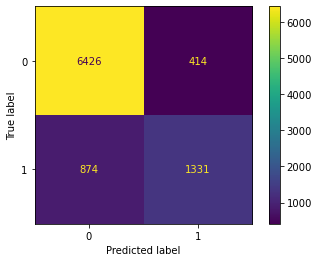

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=adaboost.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaboost.classes_)
display.plot()
plt.show()

### ROC ( Area under the curve ) plot before optimized 

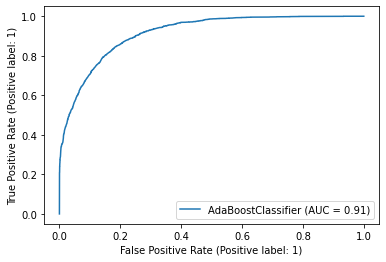

In [47]:
from sklearn.metrics import RocCurveDisplay
adaboost_roc = RocCurveDisplay.from_estimator(adaboost, X_test, y_test)
plt.show()

# Optimizing Ada_Boost 

## Improving Results (Improving Ada-Boost model performance)

In this section, we will perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [48]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier


# Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and Optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8664
Final F-score on the testing data: 0.7432


### Finding the best Hyperparameters after the tunning

In [49]:
grid_fit.best_estimator_

AdaBoostClassifier(n_estimators=500, random_state=0)

### ROC ( Area under the curve ) plot after tunning the model

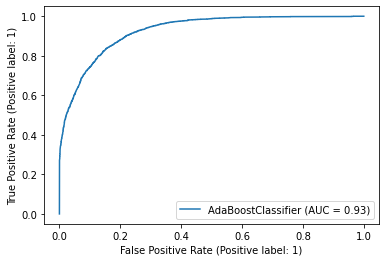

In [50]:
from sklearn.metrics import RocCurveDisplay
best_clf_roc = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

### Final Decision Tree Model Evaluation ( Unoptimized vs Optimized )

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8576           |  0.8677         |
| F-score        |  0.7246           |  0.7432         |

**Answer: ** 

The result shows the scores of the optimized model shows that it slightly performs better than the unoptimzed model.

# Model Implemenation : K-Nearest Neighbors 

In [51]:
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### For K = 1

In [52]:
knn_1 = KNeighborsClassifier(n_neighbors=1)

### Learning Curve ( K = 1 )

In [27]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    knn = knn_1
# Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',knn_1]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.7838584853510226, 0.7967938087341072, 0.7919062361786819, 0.7870411322423706, 0.7901371074745688]

Mean Cross Validation Accuracy:
-------------------------
0.7899473539961502

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.004387883647643029

Training Accuracy:
---------------
0.9625403564636681




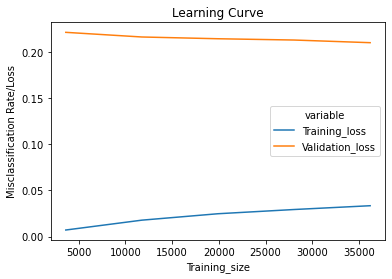

In [28]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

### Speed of KNN( k = 1 ) on the training data set

In [53]:
%%time
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train,y_train)

CPU times: user 14.5 ms, sys: 2.9 ms, total: 17.4 ms
Wall time: 15.4 ms


KNeighborsClassifier(n_neighbors=1)

### Speed of KNN ( k = 1) on the testing data set

In [54]:
%%time
predictions = knn_1.predict(X_test)

CPU times: user 7.99 s, sys: 3.23 s, total: 11.2 s
Wall time: 5.83 s


In [57]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6840
           1       0.58      0.58      0.58      2205

    accuracy                           0.79      9045
   macro avg       0.72      0.72      0.72      9045
weighted avg       0.80      0.79      0.79      9045



## Cross validation scores for training and testing data sets, KNN ( k = 1 )

In [67]:
# import the necessary libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
knn1_training_labels = knn_1.predict(X_train) 
knn1_test_labels = knn_1.predict(X_test)

# print cross validation scores
print("Cross validation scores for training labels")
print("Training accuracy score :",accuracy_score(y_train, knn1_training_labels))
print("Training precision score :",precision_score(y_train, knn1_training_labels))
print("Training recall score :",recall_score(y_train, knn1_training_labels))
print("Training F1-score :",f1_score(y_train, knn1_training_labels))
print("Training Fbeta-score :",fbeta_score(y_train, knn1_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score :",accuracy_score(y_test, knn1_test_labels))
print("Testing precision score :",precision_score(y_test, knn1_test_labels))
print("Testing recall score :",recall_score(y_test, knn1_test_labels))
print("Testing F1-score :",f1_score(y_test, knn1_test_labels))
print("Testing Fbeta-score :",fbeta_score(y_test, knn1_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score : 0.9674102330209802
Training precision score : 0.9374860210243793
Training recall score : 0.9311340664223037
Training F1-score : 0.9342992477013096
Training Fbeta-score : 0.9362087065287799


Cross validation scores for testing(validataion) labels
Testing accuracy score : 0.7946932006633499
Testing precision score : 0.5785198555956679
Testing recall score : 0.5814058956916099
Testing F1-score : 0.5799592852295861
Testing Fbeta-score : 0.5790947691751739



### Confusion matrix

##### confusion matrix plot 
True positive (TP) : 5906
True negative (TN) : 1282
False postive (FP - type 1 error ) : 934
False negative (FN - type 2 error ) : 923

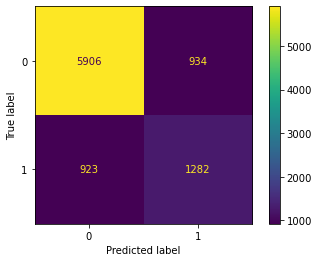

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=knn_1.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_1.classes_)
display.plot()
plt.show()

### ROC ( Area under the curve ) plot for K=1 before tunning 

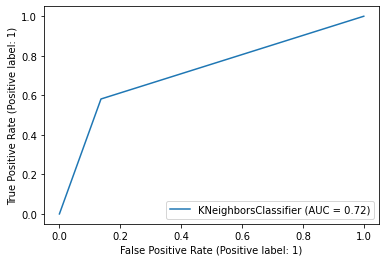

In [56]:
from sklearn.metrics import RocCurveDisplay
knn_1_roc = RocCurveDisplay.from_estimator(knn_1, X_test, y_test)
plt.show()

## Optimizing KNN ( Choosing a better K value)

Using the elbow method to pick a good K Value!

** Create a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.**

In [36]:
error_rate = []

# Will take some time
for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

### create the following plot using the information from your for loop

Text(0, 0.5, 'Error Rate')

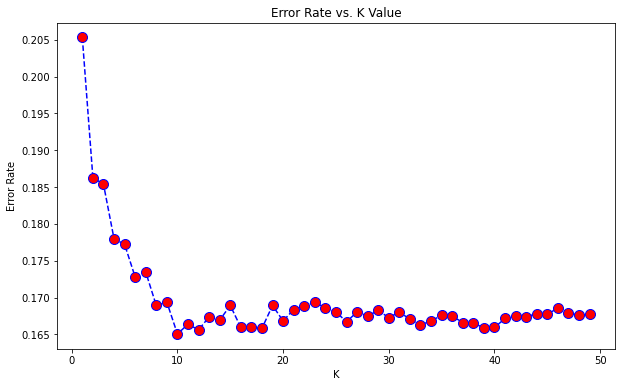

In [37]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### Speed of KNN ( k = 10 ) on the training data set

In [52]:
%%time
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(X_train,y_train)


CPU times: user 13 ms, sys: 4.46 ms, total: 17.5 ms
Wall time: 15.7 ms


KNeighborsClassifier(n_neighbors=10)

### Speed of KNN ( k = 10 ) on the testing data set

In [53]:
%%time
knn_10.predict(X_test)

CPU times: user 10 s, sys: 3.65 s, total: 13.7 s
Wall time: 8.5 s


array([0, 1, 0, ..., 0, 0, 1])

In [70]:
# NOW WITH K=10
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_10.fit(X_train,y_train)
pred = knn_10.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6840
           1       0.71      0.54      0.62      2205

    accuracy                           0.83      9045
   macro avg       0.79      0.74      0.76      9045
weighted avg       0.83      0.83      0.83      9045



In [54]:
# import necessary libraries
from sklearn.metrics import accuracy_score
RF_training_labels = knn_10.predict(X_train) 
RF_test_labels = knn_10.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
knn10_training_labels = knn_10.predict(X_train) 
knn10_test_labels = knn_10.predict(X_test)

# printing cross validation scores
print("Cross validation scores for training labels")
print("Training accuracy score :",accuracy_score(y_train, knn10_training_labels))
print("Training precision score :",precision_score(y_train, knn10_training_labels))
print("Training recall score :",recall_score(y_train, knn10_training_labels))
print("Training F1-score :",f1_score(y_train, knn10_training_labels))
print("Training Fbeta-score :",fbeta_score(y_train, knn10_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score :",accuracy_score(y_test, knn10_test_labels))
print("Testing precision score :",precision_score(y_test, knn10_test_labels))
print("Testing recall score :",recall_score(y_test, knn10_test_labels))
print("Testing F1-score :",f1_score(y_test, knn10_test_labels))
print("Testing Fbeta-score :",fbeta_score(y_test, knn10_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score : 0.8576443596760372
Training precision score : 0.7752536076582369
Training recall score : 0.6026879928912585
Training F1-score : 0.6781652293463318
Training Fbeta-score : 0.7332630611638152


Cross validation scores for testing(validataion) labels
Testing accuracy score : 0.8349364289662797
Testing precision score : 0.7109004739336493
Testing recall score : 0.54421768707483
Testing F1-score : 0.6164911379398922
Testing Fbeta-score : 0.6698671430166351



In [45]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    knn = knn_10
# Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',knn_10]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.8342730790491985, 0.8298507462686567, 0.8293896505970809, 0.820765148164529, 0.8301636444051305]

Mean Cross Validation Accuracy:
-------------------------
0.828888453696919

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.004422343261793048

Training Accuracy:
---------------
0.8554685772411658




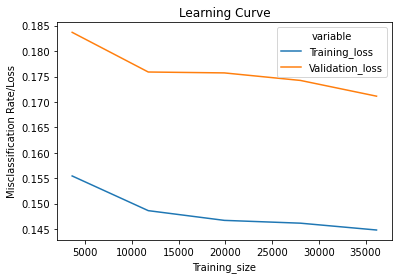

In [46]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

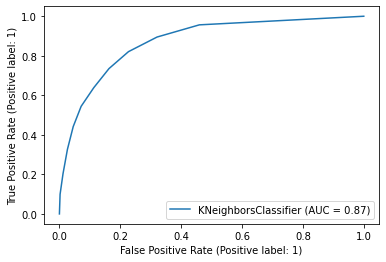

In [59]:
from sklearn.metrics import RocCurveDisplay
knn_10_roc = RocCurveDisplay.from_estimator(knn_10, X_test, y_test)
plt.show()

## Optimizing KNN 

## Improving Results (Improving KNN model performance)

In this section, we will perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

##### NOTE : KNN optimization idea taken from the following link : https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

In [60]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Initialize the classifier
clf = KNeighborsClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_neighbors':[10,15,25,40],
              'weights':['uniform','distance'],
              'metric':['euclidean', 'manhattan']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and Optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8228
F-score on testing data: 0.6374

Optimized Model
------
Final accuracy score on the testing data: 0.8335
Final F-score on the testing data: 0.6629


In [61]:
grid_fit.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=25)

### ROC ( Area under the curve ) plot after tunning for k=25

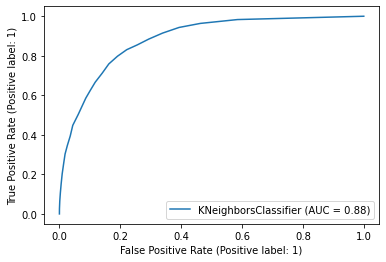

In [62]:
from sklearn.metrics import RocCurveDisplay
best_clf_roc = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

### Finding the best Hyperparameters after the tunning

### Final Decision Tree Model Evaluation ( Unoptimized vs Optimized )

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8228           |  0.8335         |
| F-score        |  0.6374           |  0.6629         |

**Answer: ** 

The result shows the scores of the optimized model shows that it slightly performs better than the unoptimzed model.

# Model Implemenation : Neural Nets 

In [60]:
#importing the necessary libraries and MLPclassifier
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The line below instantiates the model with the 'hidden_layer_sizes' argument set to three layers, which has the same number of neurons(i.e. 10 neurons each) as the count of features in the dataset. We will also select 'relu' as the activation function and 'adam' as the solver for weight optimization and with 300 epochs ( iterations ).

In [61]:
#The line below instantiates the model with the 'hidden_layer_sizes' argument set to three layers, 
#which has the same number of neurons(i.e. 10 neurons each) as the count of features in the dataset. 
#We will also select 'relu' as the activation function and 'adam' as the solver for weight optimization 
#and with 100 epochs ( iterations ).

nnets = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', max_iter=500)

# Learning Curve on NN 

In [83]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preferred method compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    #le = LabelEncoder() # Label encoding the target
    le = preprocessing.LabelEncoder()
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    #log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    nn = nnets
# Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',nn]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

Cross Validation Accuracies:
-------------------------
[0.8126036484245439, 0.8158098396904367, 0.8216497125165856, 0.8074966828836798, 0.8213180008845643]

Mean Cross Validation Accuracy:
-------------------------
0.8157755768799622

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.005363325893368643

Training Accuracy:
---------------
0.9119012869842112




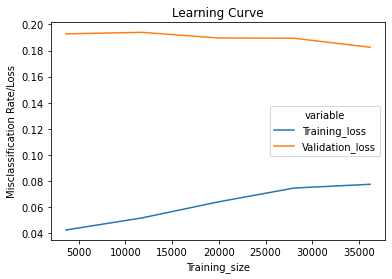

In [84]:
lc = learn_curve(features_final,income,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss");

## Speeed of NN on the training data set 

In [62]:
%%time
nnets = nnets = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', max_iter=500)
nnets.fit(X_train,y_train)

CPU times: user 6min 2s, sys: 2.25 s, total: 6min 5s
Wall time: 1min 31s


MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500)

## Speed of NN on the testing data set

In [69]:
%%time
predictions = nnets.predict(X_test)

CPU times: user 114 ms, sys: 9.07 ms, total: 123 ms
Wall time: 30.7 ms


In [87]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6840
           1       0.65      0.62      0.63      2205

    accuracy                           0.82      9045
   macro avg       0.76      0.75      0.76      9045
weighted avg       0.82      0.82      0.82      9045



## Cross validation scores for training and testing data sets, NN 

In [88]:
# importing the necessary libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
nnets_training_labels = nnets.predict(X_train) 
nnets_test_labels = nnets.predict(X_test)

#printing cross validation scores
print("Cross validation scores for training labels")
print("Training accuracy score :",accuracy_score(y_train, nnets_training_labels))
print("Training precision score :",precision_score(y_train, nnets_training_labels))
print("Training recall score :",recall_score(y_train, nnets_training_labels))
print("Training F1-score :",f1_score(y_train, nnets_training_labels))
print("Training Fbeta-score :",fbeta_score(y_train, nnets_training_labels, beta=0.5))
print("\n")
print("Cross validation scores for testing(validataion) labels")
print("Testing accuracy score :",accuracy_score(y_test, nnets_test_labels))
print("Testing precision score :",precision_score(y_test, nnets_test_labels))
print("Testing recall score :",recall_score(y_test, nnets_test_labels))
print("Testing F1-score :",f1_score(y_test, nnets_test_labels))
print("Testing Fbeta-score :",fbeta_score(y_test, nnets_test_labels, beta=0.5))
print("")

Cross validation scores for training labels
Training accuracy score : 0.9056030074356636
Training precision score : 0.8254134637782437
Training recall score : 0.7871820504276352
Training F1-score : 0.8058445619421228
Training Fbeta-score : 0.8174729508385817


Cross validation scores for testing(validataion) labels
Testing accuracy score : 0.8239911553344389
Testing precision score : 0.6458829128986197
Testing recall score : 0.6154195011337869
Testing F1-score : 0.6302833255921969
Testing Fbeta-score : 0.6395513243472524



#### confusion matrix 

##### confusion matrix plot 
True positive (TP) : 6239
True negative (TN) : 1215
False postive (FP - type 1 error ) : 601
False negative (FN - type 2 error ) : 990

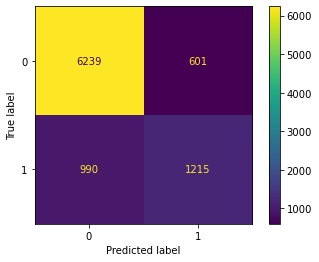

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=nnets.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nnets.classes_)
display.plot()
plt.show()

### ROC ( Area under the curve ) plot before tunning

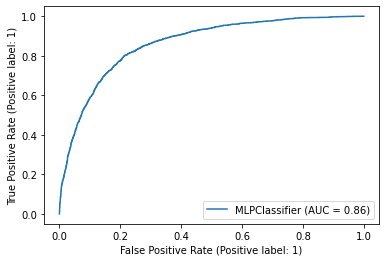

In [71]:
from sklearn.metrics import RocCurveDisplay
nnets_disp = RocCurveDisplay.from_estimator(nnets, X_test, y_test)
plt.show()

## Optimizing Neural Nets

## Improving Results (Improving Neural Nets model performance)

In this section, we will perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [85]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC


# Initialize the classifier
nnets = MLPClassifier(max_iter=500)


# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'hidden_layer_sizes': [(50,55,60)],
    'activation': ['tanh', 'relu'],
    'max_iter': [1000],
    'solver': ['sgd', 'adam']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(nnets, parameters,scoring = scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
#best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8228
F-score on testing data: 0.6374

Optimized Model
------
Final accuracy score on the testing data: 0.8405
Final F-score on the testing data: 0.6778


In [86]:
grid_fit.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 55, 60), max_iter=1000,
              solver='sgd')

### ROC ( Aread under the curve ) plot after tunning 

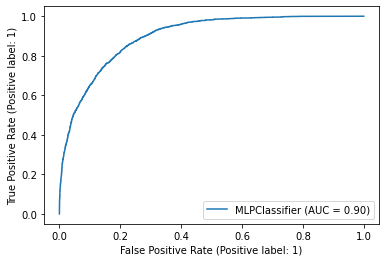

In [87]:
from sklearn.metrics import RocCurveDisplay
best_clf_roc = RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.show()

### Finding the best Hyperparameters after the tunning

### Final Neural Nets Model Evaluation ( Unoptimized vs Optimized )

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8228           |  0.8405         |
| F-score        |  0.6374           |  0.6778         |

**Answer: ** 

The result shows the scores of the optimized model shows that it slightly performs better than the unoptimzed model.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Implementation - Extracting Feature Importance for Adaboost
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

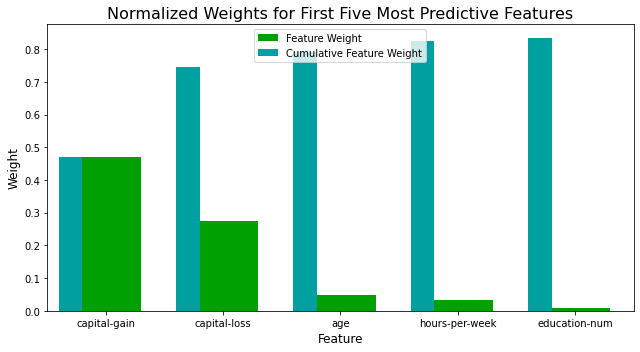

In [65]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=0,n_estimators=500).fit(X_train, y_train)


# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

**Answer:**

Interestingly capital-gain and capital-loss seems to be the most relevant features which i didn't expect. However even though the order exactly didn't match age, education level and hours-per-week happens to be in the top five which confirms my thought that those features are high indicators of income distribution. I believe people who make wise decisions in investing can factor the pridictive power of the algorithm.   

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [67]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8664
F-score on testing data: 0.7432

Final Model trained on reduced data
------
Accuracy on testing data: 0.8426
F-score on testing data: 0.7044


**Answer:**

Reducing the features reduces the accuracy and f-score. In my opinion this is because of the fact that the other features contributes to the difference in the result even though it's not significant. However, if training time was a factor, reducing the features plays a paramount role in reducing the training time.